## Inference with an MMPose model

MMPose provides high-level APIs for model inference and training.

In [6]:
import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope
import numpy as np

import sys
sys.path.append('/home/moriki/PoseEstimation/mmpose')

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

# local_runtime = False

# try:
#     from google.colab.patches import cv2_imshow  # for image visualization in colab
# except:
#     local_runtime = True
    
# Specify the image file
img = '/home/moriki/PoseEstimation/mmpose/data/pose/CrowdPose/images-origin/100000.jpg'

# Correct the path to the pose estimation model configuration file
pose_config = '/home/moriki/PoseEstimation/mmpose/configs/body_2d_keypoint/rtmo/crowdpose/rtmo-l_16xb16-700e_body7-crowdpose-640x640.py'
pose_checkpoint = '/home/moriki/PoseEstimation/mmpose/models/rtmo-l_16xb16-700e_body7-crowdpose-640x640-5bafdc11_20231219.pth'
det_config = '/home/moriki/PoseEstimation/mmpose/demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

device = 'cuda:0'
cfg_options = None  # Assuming default configuration should work unless you have specific modifications to make

# Initialize the object detector
detector = init_detector(
    det_config,
    det_checkpoint,
    device=device
)

# Initialize the pose estimator
pose_estimator = init_pose_estimator(
    pose_config,
    pose_checkpoint,
    device=device,
    cfg_options=cfg_options
)

# Initialize the visualizer with specific settings
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# Dataset meta-information is loaded from the checkpoint and passed to the model
visualizer.set_dataset_meta(pose_estimator.dataset_meta)


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by local backend from path: /home/moriki/PoseEstimation/mmpose/models/rtmo-l_16xb16-700e_body7-crowdpose-640x640-5bafdc11_20231219.pth


/home/moriki/.pyenv/versions/3.9.7/envs/mmpose-env/lib/python3.9/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [7]:

def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file):
    """Visualize predicted keypoints (and heatmaps) of one image."""

    # predict bbox
    scope = detector.cfg.get('default_scope', 'mmdet')
    if scope is not None:
        init_default_scope(scope)
    detect_result = inference_detector(detector, img_path)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img_path, bboxes)
    data_samples = merge_data_samples(pose_results)

    # show the results
    img = mmcv.imread(img_path, channel_order='rgb')

    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_thr=0.3)

In [8]:
visualize_img(
    img,
    detector,
    pose_estimator,
    visualizer,
    show_interval=0,
    out_file=None)

vis_result = visualizer.get_image()

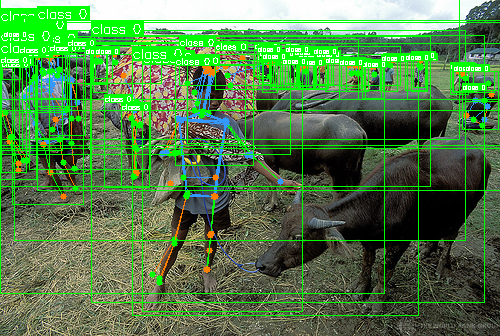

In [9]:
from IPython.display import Image, display
import tempfile
import os.path as osp
import cv2
with tempfile.TemporaryDirectory() as tmpdir:
    file_name = osp.join(tmpdir, 'pose_results.png')
    cv2.imwrite(file_name, vis_result[:,:,::-1])
    display(Image(file_name))


In [ ]:
visualizer.draw_featmap(feat, img, channel_reduction='select_max')

In [12]:
vis_result.shape

(336, 500, 3)

In [5]:
print(vis_result.shape)
print(type(vis_result))

(336, 500, 3)
<class 'numpy.ndarray'>


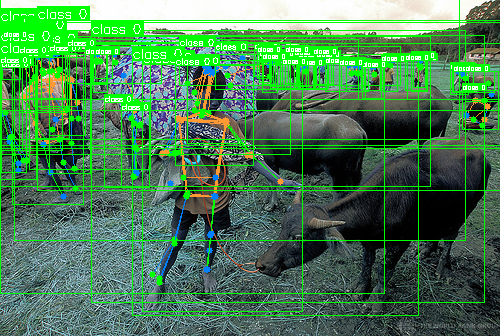

In [11]:
from PIL import Image
from IPython.display import display

# 画像を読み込む
img = Image.fromarray(vis_result[:,:,::-1])

# 画像を表示する
display(img)

### Add a new dataset

There are two methods to support a customized dataset in MMPose. The first one is to convert the data to a supported format (e.g. COCO) and use the corresponding dataset class (e.g. BaseCocoStyleDataset), as described in the [document](https://mmpose.readthedocs.io/en/1.x/user_guides/prepare_datasets.html). The second one is to add a new dataset class. In this tutorial, we give an example of the second method.

We first download the demo dataset, which contains 100 samples (75 for training and 25 for validation) selected from COCO train2017 dataset. The annotations are stored in a different format from the original COCO format.


In [ ]:
# download dataset
%mkdir data
%cd data
!wget https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar
!tar -xf coco_tiny.tar
%cd ..

/content/mmpose/data
--2022-09-14 10:39:37--  https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar
Resolving download.openmmlab.com (download.openmmlab.com)... 47.89.140.71
Connecting to download.openmmlab.com (download.openmmlab.com)|47.89.140.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16558080 (16M) [application/x-tar]
Saving to: ‘coco_tiny.tar’

coco_tiny.tar       100%[===================>]  15.79M  9.14MB/s    in 1.7s    

2022-09-14 10:39:40 (9.14 MB/s) - ‘coco_tiny.tar’ saved [16558080/16558080]

/content/mmpose


In [ ]:
# check the directory structure
!apt-get -q install tree
!tree data/coco_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (161 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
data/coco_tiny
├── images
│   ├── 000000012754.jpg
│   ├── 000000017741.jpg
│   ├── 000000019157.jpg
│   ├── 000000019523.jpg
│   ├── 000000019608.jpg
│   ├── 

In [ ]:
# check the annotation format
import json
import pprint

anns = json.load(open('data/coco_tiny/train.json'))

print(type(anns), len(anns))
pprint.pprint(anns[0], compact=True)

<class 'list'> 75
{'bbox': [267.03, 104.32, 229.19, 320],
 'image_file': '000000537548.jpg',
 'image_size': [640, 480],
 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 160, 2, 398,
               177, 2, 0, 0, 0, 437, 238, 2, 0, 0, 0, 477, 270, 2, 287, 255, 1,
               339, 267, 2, 0, 0, 0, 423, 314, 2, 0, 0, 0, 355, 367, 2]}


After downloading the data, we implement a new dataset class to load data samples for model training and validation. Assume that we are going to train a top-down pose estimation model, the new dataset class inherits `BaseCocoStyleDataset`.

We have already implemented a `CocoDataset` so that we can take it as an example.

#### Note
If you meet the following error:
```shell
AssertionError: class `PoseLocalVisualizer` in mmpose/visualization/local_visualizer.py: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not access any other arguments
```
Please reboot your jupyter kernel and start running from here.

In [ ]:
%cd mmpose

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import json
import os.path as osp
from typing import Callable, List, Optional, Sequence, Union

import numpy as np
from mmengine.utils import check_file_exist

from mmpose.registry import DATASETS
from mmpose.datasets.datasets.base import BaseCocoStyleDataset


@DATASETS.register_module()
class TinyCocoDataset(BaseCocoStyleDataset):
    METAINFO: dict = dict(from_file='configs/_base_/datasets/coco.py')

    def _load_annotations(self) -> List[dict]:
        """Load data from annotations in MPII format."""

        check_file_exist(self.ann_file)
        with open(self.ann_file) as anno_file:
            anns = json.load(anno_file)

        data_list = []
        ann_id = 0

        for idx, ann in enumerate(anns):
            img_h, img_w = ann['image_size']

            # get bbox in shape [1, 4], formatted as xywh
            x, y, w, h = ann['bbox']
            x1 = np.clip(x, 0, img_w - 1)
            y1 = np.clip(y, 0, img_h - 1)
            x2 = np.clip(x + w, 0, img_w - 1)
            y2 = np.clip(y + h, 0, img_h - 1)

            bbox = np.array([x1, y1, x2, y2], dtype=np.float32).reshape(1, 4)

            # load keypoints in shape [1, K, 2] and keypoints_visible in [1, K]
            joints_3d = np.array(ann['keypoints']).reshape(1, -1, 3)
            num_joints = joints_3d.shape[1]
            keypoints = np.zeros((1, num_joints, 2), dtype=np.float32)
            keypoints[:, :, :2] = joints_3d[:, :, :2]
            keypoints_visible = np.minimum(1, joints_3d[:, :, 2:3])
            keypoints_visible = keypoints_visible.reshape(1, -1)

            data_info = {
                'id': ann_id,
                'img_id': int(ann['image_file'].split('.')[0]),
                'img_path': osp.join(self.data_prefix['img'], ann['image_file']),
                'bbox': bbox,
                'bbox_score': np.ones(1, dtype=np.float32),
                'keypoints': keypoints,
                'keypoints_visible': keypoints_visible,
            }

            data_list.append(data_info)
            ann_id = ann_id + 1

        return data_list, None


### Create a config file

In the next step, we create a config file which configures the model, dataset and runtime settings. More information can be found at [Configs](https://mmpose.readthedocs.io/en/1.x/user_guides/configs.html). A common practice to create a config file is deriving from a existing one. In this tutorial, we load a config file that trains a HRNet on COCO dataset, and modify it to adapt to the COCOTiny dataset.

In [ ]:
from mmengine import Config

cfg = Config.fromfile(
    './configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py'
)

# set basic configs
cfg.data_root = 'data/coco_tiny'
cfg.work_dir = 'work_dirs/hrnet_w32_coco_tiny_256x192'
cfg.randomness = dict(seed=0)

# set log interval
cfg.train_cfg.val_interval = 1

# set num of epoch
cfg.train_cfg.max_epochs = 40

# set optimizer
cfg.optim_wrapper = dict(optimizer=dict(
    type='Adam',
    lr=5e-4,
))

# set learning rate policy
cfg.param_scheduler = [
    dict(
        type='LinearLR', begin=0, end=10, start_factor=0.001,
        by_epoch=False),  # warm-up
    dict(
        type='MultiStepLR',
        begin=0,
        end=cfg.train_cfg.max_epochs,
        milestones=[17, 35],
        gamma=0.1,
        by_epoch=True)
]


# set batch size
cfg.train_dataloader.batch_size = 16
cfg.val_dataloader.batch_size = 16
cfg.test_dataloader.batch_size = 16

# set dataset configs
cfg.dataset_type = 'TinyCocoDataset'
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.ann_file = 'train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img='images/')


cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.bbox_file = None
cfg.val_dataloader.dataset.ann_file = 'val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img='images/')

cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.bbox_file = None
cfg.test_dataloader.dataset.ann_file = 'val.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix = dict(img='images/')

# set evaluator
cfg.val_evaluator = dict(type='PCKAccuracy')
cfg.test_evaluator = cfg.val_evaluator

cfg.default_hooks.checkpoint.save_best = 'PCK'
cfg.default_hooks.checkpoint.max_keep_ckpts = 1

print(cfg.pretty_text)


default_scope = 'mmpose'
default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=50),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(
        type='CheckpointHook',
        interval=1,
        save_best='pck/PCK@0.05',
        rule='greater',
        max_keep_ckpts=1),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    visualization=dict(type='PoseVisualizationHook', enable=False))
custom_hooks = [dict(type='SyncBuffersHook')]
env_cfg = dict(
    cudnn_benchmark=False,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [dict(type='LocalVisBackend')]
visualizer = dict(
    type='PoseLocalVisualizer',
    vis_backends=[dict(type='LocalVisBackend')],
    name='visualizer')
log_processor = dict(
    type='LogProcessor', window_size=50, by_epoch=True, num_digits=6)
log_level = 'INFO'
load_from = None
resume = False
file_client_args = dict(backend='disk'

or you can create a config file like follows:
```Python3
_base_ = ['../../../_base_/default_runtime.py']

# runtime
train_cfg = dict(max_epochs=40, val_interval=1)

# optimizer
optim_wrapper = dict(optimizer=dict(
    type='Adam',
    lr=5e-4,
))

# learning policy
param_scheduler = [
    dict(
        type='LinearLR', begin=0, end=500, start_factor=0.001,
        by_epoch=False),  # warm-up
    dict(
        type='MultiStepLR',
        begin=0,
        end=train_cfg.max_epochs,
        milestones=[17, 35],
        gamma=0.1,
        by_epoch=True)
]

# automatically scaling LR based on the actual training batch size
auto_scale_lr = dict(base_batch_size=512)

# codec settings
codec = dict(
    type='MSRAHeatmap', input_size=(192, 256), heatmap_size=(48, 64), sigma=2)

# model settings
model = dict(
    type='TopdownPoseEstimator',
    data_preprocessor=dict(
        type='PoseDataPreprocessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True),
    backbone=dict(
        type='HRNet',
        in_channels=3,
        extra=dict(
            stage1=dict(
                num_modules=1,
                num_branches=1,
                block='BOTTLENECK',
                num_blocks=(4, ),
                num_channels=(64, )),
            stage2=dict(
                num_modules=1,
                num_branches=2,
                block='BASIC',
                num_blocks=(4, 4),
                num_channels=(32, 64)),
            stage3=dict(
                num_modules=4,
                num_branches=3,
                block='BASIC',
                num_blocks=(4, 4, 4),
                num_channels=(32, 64, 128)),
            stage4=dict(
                num_modules=3,
                num_branches=4,
                block='BASIC',
                num_blocks=(4, 4, 4, 4),
                num_channels=(32, 64, 128, 256))),
        init_cfg=dict(
            type='Pretrained',
            checkpoint='https://download.openmmlab.com/mmpose/'
            'pretrain_models/hrnet_w32-36af842e.pth'),
    ),
    head=dict(
        type='HeatmapHead',
        in_channels=32,
        out_channels=17,
        deconv_out_channels=None,
        loss=dict(type='KeypointMSELoss', use_target_weight=True),
        decoder=codec),
    test_cfg=dict(
        flip_test=True,
        flip_mode='heatmap',
        shift_heatmap=True,
    ))

# base dataset settings
dataset_type = 'TinyCocoDataset'
data_mode = 'topdown'
data_root = 'data/coco_tiny'
work_dir = 'work_dirs/hrnet_w32_coco_tiny_256x192'
randomness = dict(seed=0)

# pipelines
train_pipeline = [
    dict(type='LoadImage'),
    dict(type='GetBBoxCenterScale'),
    dict(type='RandomFlip', direction='horizontal'),
    dict(type='RandomHalfBody'),
    dict(type='RandomBBoxTransform'),
    dict(type='TopdownAffine', input_size=codec['input_size']),
    dict(type='GenerateTarget', target_type='heatmap', encoder=codec),
    dict(type='PackPoseInputs')
]
test_pipeline = [
    dict(type='LoadImage'),
    dict(type='GetBBoxCenterScale'),
    dict(type='TopdownAffine', input_size=codec['input_size']),
    dict(type='PackPoseInputs')
]

# data loaders
train_dataloader = dict(
    batch_size=16,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_mode=data_mode,
        ann_file='train.json',
        data_prefix=dict(img='images/'),
        pipeline=train_pipeline,
    ))
val_dataloader = dict(
    batch_size=16,
    num_workers=2,
    persistent_workers=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False, round_up=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_mode=data_mode,
        ann_file='val.json',
        data_prefix=dict(img='images/'),
        test_mode=True,
        pipeline=test_pipeline,
    ))
test_dataloader = val_dataloader

# evaluators
val_evaluator = dict(
    type='PCKAccuracy')
test_evaluator = val_evaluator

# hooks
default_hooks = dict(checkpoint=dict(save_best='coco/AP', rule='greater'))
```

### Train and Evaluation


In [ ]:
from mmengine.config import Config, DictAction
from mmengine.runner import Runner

# set preprocess configs to model
cfg.model.setdefault('data_preprocessor', cfg.get('preprocess_cfg', {}))

# build the runner from config
runner = Runner.from_cfg(cfg)

# start training
runner.train()

09/15 12:42:06 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
09/15 12:42:06 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.13 (default, Mar 29 2022, 02:18:16) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce GTX 1660 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.3, V11.3.109
    GCC: gcc (Ubuntu 5.4.0-6ubuntu1~16.04.12) 5.4.0 20160609
    PyTorch: 1.12.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 2019112

TopdownPoseEstimator(
  (data_preprocessor): PoseDataPreprocessor()
  (backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm

#### Note
The recommended best practice is to convert your customized data into COCO format.